# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [3]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847933 entries, 0 to 1847932
Data columns (total 13 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   mes             object
 3   dia             object
 4   dia_fecha       int64 
 5   hora_inicio     int64 
 6   hora_fin        int64 
 7   estacion        object
 8   tipo_vehiculo   object
 9   forma_pago      object
 10  observacion     object
 11  sentido         object
 12  cantidad_pasos  int64 
dtypes: int64(5), object(8)
memory usage: 183.3+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Centro,24
1,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80
2,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1
3,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1
4,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1


In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [7]:
data_2016.info()
data_2016.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,NO COBRADO,32
1,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,AUPASS,9
2,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,NO COBRADO,1
3,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EFECTIVO,4
4,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EXENTO,3


In [8]:
print(data_2020.isnull().sum())
print(data_2019.isnull().sum())
print(data_2018.isnull().sum())
print(data_2017.isnull().sum())
print(data_2016.isnull().sum())

periodo           0
fecha             0
mes               0
dia               0
dia_fecha         0
hora_inicio       0
hora_fin          0
estacion          0
tipo_vehiculo     0
forma_pago        0
observacion       0
sentido           0
cantidad_pasos    0
dtype: int64
periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64
periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64
periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64
periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia     

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [9]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())
print(data_2016['estacion'].unique())
print(data_2020['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']


In [10]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
print(data_2016['sentido'].unique())
print(data_2020['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [11]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())
print(data_2016['tipo_vehiculo'].unique())
print(data_2020['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']


In [12]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())
print(data_2016['forma_pago'].unique())
print(data_2020['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']
['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']


In [13]:
data_2019['forma_pago'] = data_2019['forma_pago'].replace(['T. DISCAPACIDAD'],'TARJETA DISCAPACIDAD')
print(data_2019['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'TARJETA DISCAPACIDAD']


In [14]:
data_2020['forma_pago'] = data_2020['forma_pago'].replace(['Efectivo'],'EFECTIVO')
print(data_2020['forma_pago'].unique())

['EFECTIVO' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']


In [15]:
data_2020['estacion'] = data_2020['estacion'].replace(['ILLIA'],'Illia')
print(data_2020['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'Illia' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']


##### Podemos decir entonces que los años 2016, 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [16]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016])

In [17]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

In [18]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

In [19]:
#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,2019-01-01,2,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,2019-01-01,2,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,2019-01-01,2,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,2019-01-01,2,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,2019-01-01,3,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [20]:
dataset.describe().round(decimals=2)

,hora_fin,cantidad_pasos
count,346566.00,346566.00
mean,11.92,193.58
std,6.73,409.65
min,0.00,1.00
25%,6.00,2.00
50%,12.00,11.00
75%,18.00,79.00
max,23.00,2575.00


In [21]:
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [22]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [23]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Viernes,Centro,Liviano,14,2016-01-01 00:00:00
1,Viernes,Centro,Pesado,3,2016-01-01 00:00:00
2,Viernes,Provincia,Liviano,66,2016-01-01 00:00:00
3,Viernes,Provincia,Pesado,1,2016-01-01 00:00:00
4,Viernes,Provincia,Pesado,4,2016-01-01 00:00:00
...,...,...,...,...,...
346561,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
346562,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
346563,Martes,Centro,Liviano,580,2019-12-31 22:00:00
346564,Martes,Centro,Liviano,214,2019-12-31 23:00:00


### 2. Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

In [24]:
data1619 = pd.concat([data_2019, data_2018, data_2017, data_2016])
data1619.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [25]:
data1619['fecha2'] = pd.to_datetime(data1619.fecha) + pd.to_timedelta(data1619.hora_fin, unit = 'h')
data1619.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53,2019-01-01 01:00:00
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18,2019-01-01 01:00:00
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01 01:00:00


In [26]:
data1619.drop(columns=['fecha', 'hora_inicio', 'hora_fin'], inplace = True)

In [27]:
data1619.rename(columns = {'fecha2':'fecha'}, inplace = True)
data1619.head()

,periodo,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2019,Martes,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00
1,2019,Martes,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00
2,2019,Martes,Alberti,Provincia,Liviano,NO COBRADO,53,2019-01-01 01:00:00
3,2019,Martes,Alberti,Provincia,Liviano,TELEPASE,18,2019-01-01 01:00:00
4,2019,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01 01:00:00


In [28]:
data1619.sort_values('fecha', inplace = True)
data1619.reset_index(drop=True, inplace = True)
data1619

,periodo,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2016,Viernes,Illia,Provincia,Pesado,EFECTIVO,1,2016-01-01 00:00:00
1,2016,Viernes,Illia,Centro,Pesado,EXENTO,4,2016-01-01 00:00:00
2,2016,Viernes,Illia,Centro,Liviano,AUPASS,195,2016-01-01 00:00:00
3,2016,Viernes,Illia,Centro,Liviano,INFRACCION,3,2016-01-01 00:00:00
4,2016,Viernes,Illia,Centro,Liviano,TARJETA DISCAPACIDAD,7,2016-01-01 00:00:00
...,...,...,...,...,...,...,...,...
4940144,2019,Martes,Illia,Centro,Liviano,TELEPASE,122,2019-12-31 23:00:00
4940145,2019,Martes,Illia,Provincia,Liviano,EXENTO,3,2019-12-31 23:00:00
4940146,2019,Martes,Illia,Provincia,Liviano,INFRACCION,2,2019-12-31 23:00:00
4940147,2019,Martes,Alberti,Provincia,Pesado,EFECTIVO,1,2019-12-31 23:00:00


In [29]:
data1619.describe().round(decimals = 2)

,periodo,cantidad_pasos
count,4940149.00,4940149.00
mean,2017.33,101.21
std,1.05,318.79
min,2016.00,1.00
25%,2016.00,2.00
50%,2017.00,8.00
75%,2018.00,32.00
max,2019.00,6677.00


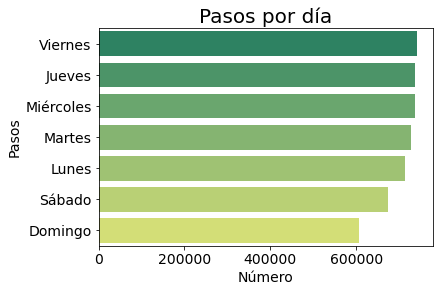

In [30]:
pasosd = sns.countplot(data = data1619, y = "dia", palette = 'summer', order = data1619['dia'].value_counts().index)
pasosd.axes.set_title("Pasos por día", fontsize=20)
pasosd.set_xlabel("Número", fontsize=14)
pasosd.set_ylabel("Pasos", fontsize=14)
pasosd.tick_params(labelsize=14)

In [31]:
data1619["dia"].value_counts(normalize = True)

Viernes      0.150301
Jueves       0.149249
Miércoles    0.149145
Martes       0.147344
Lunes        0.144507
Sábado       0.136474
Domingo      0.122981
Name: dia, dtype: float64

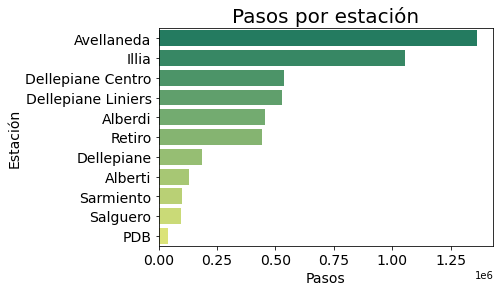

In [32]:
pasose = sns.countplot(data = data1619, y = "estacion", palette = 'summer', order = data1619['estacion'].value_counts().index)
pasose.axes.set_title("Pasos por estación", fontsize=20)
pasose.set_xlabel("Pasos", fontsize=14)
pasose.set_ylabel("Estación", fontsize=14)
pasose.tick_params(labelsize=14)

In [33]:
data1619["estacion"].value_counts(normalize = True)

Avellaneda            0.276271
Illia                 0.213650
Dellepiane Centro     0.108333
Dellepiane Liniers    0.107280
Alberdi               0.092281
Retiro                0.089889
Dellepiane            0.037975
Alberti               0.026776
Sarmiento             0.019923
Salguero              0.019330
PDB                   0.008292
Name: estacion, dtype: float64

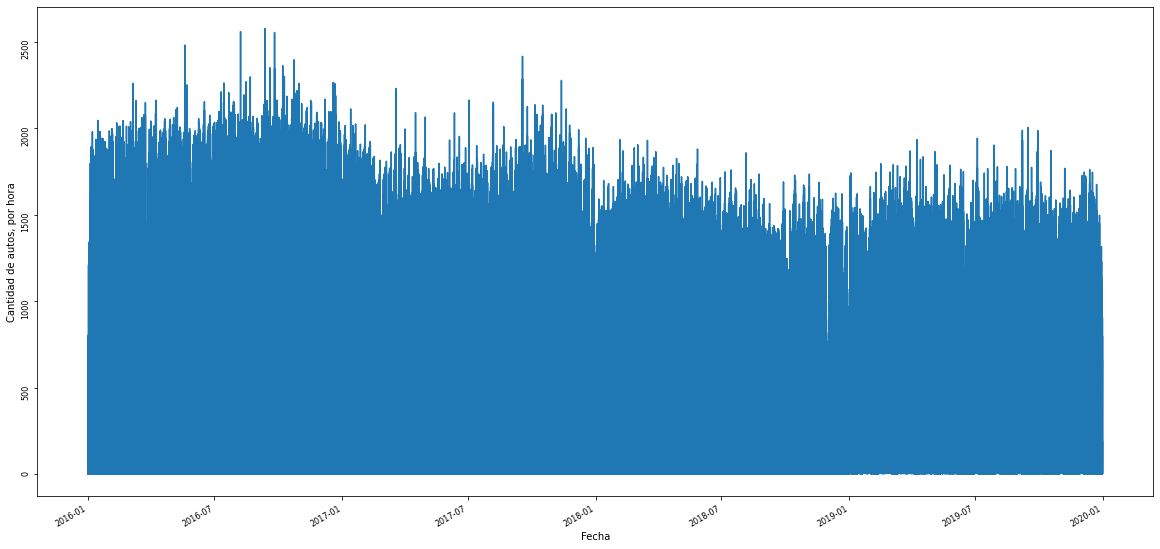

In [34]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (20,10))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por hora')
plt.tick_params(labelsize=8, rotation=90)
plt.gcf().autofmt_xdate()
plt.show()

In [35]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1461, 1)


,cantidad_pasos
fecha,
2016-01-01,25602
2016-01-02,36136
2016-01-03,37225
2016-01-04,50312
2016-01-05,49907


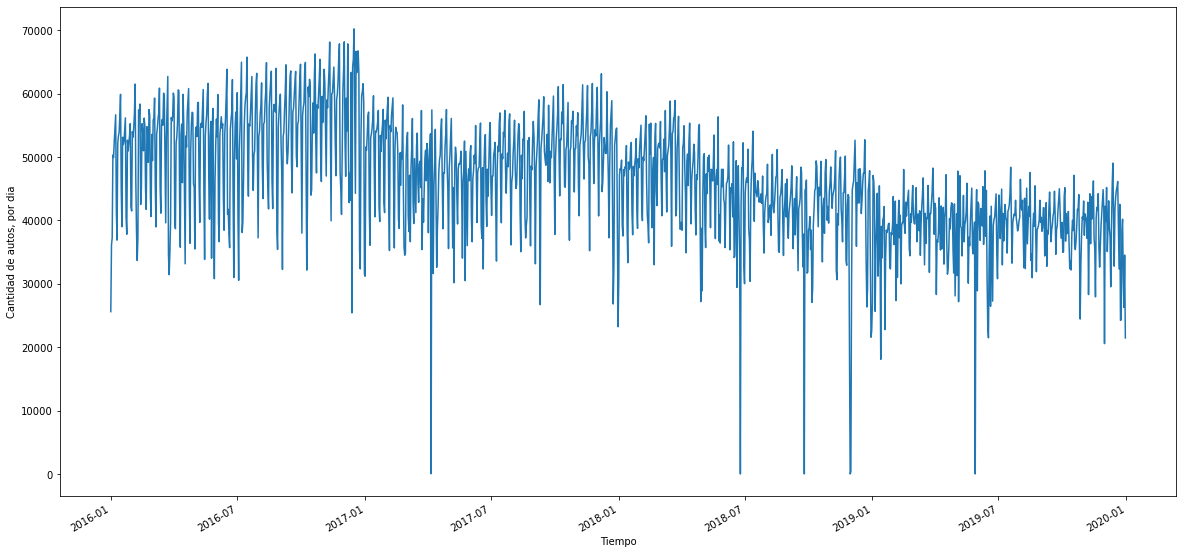

In [36]:
plt.figure(figsize = (20,10))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.gcf().autofmt_xdate()
plt.show()

In [37]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semana = dataset.resample('W', on = 'fecha').sum()
print(semana.shape)
semana.head()

(210, 1)


,cantidad_pasos
fecha,
2016-01-03,98963
2016-01-10,342201
2016-01-17,359649
2016-01-24,346217
2016-01-31,348221


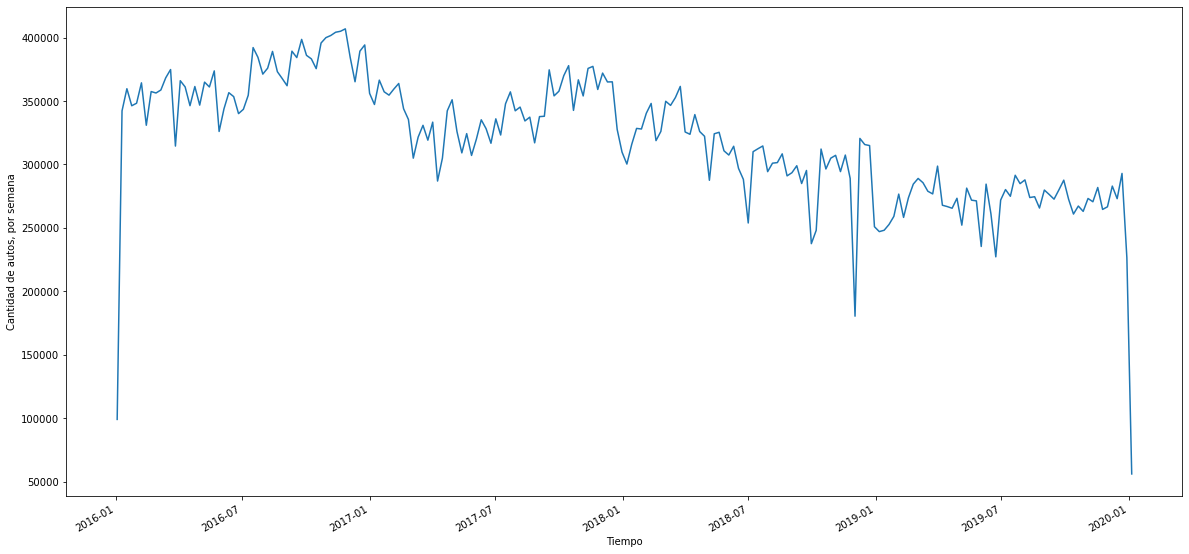

In [38]:
plt.figure(figsize = (20,10))
plt.plot(semana.index, semana.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.gcf().autofmt_xdate()
plt.show()

In [39]:
#Resampleamos nuestros datos para agrupar por mes, y asi tal vez lograr una visualización mas amigable
mes = dataset.resample('M', on = 'fecha').sum()
print(mes.shape)
mes.head()

(48, 1)


,cantidad_pasos
fecha,
2016-01-31,1495251
2016-02-29,1462367
2016-03-31,1590835
2016-04-30,1517590
2016-05-31,1559386


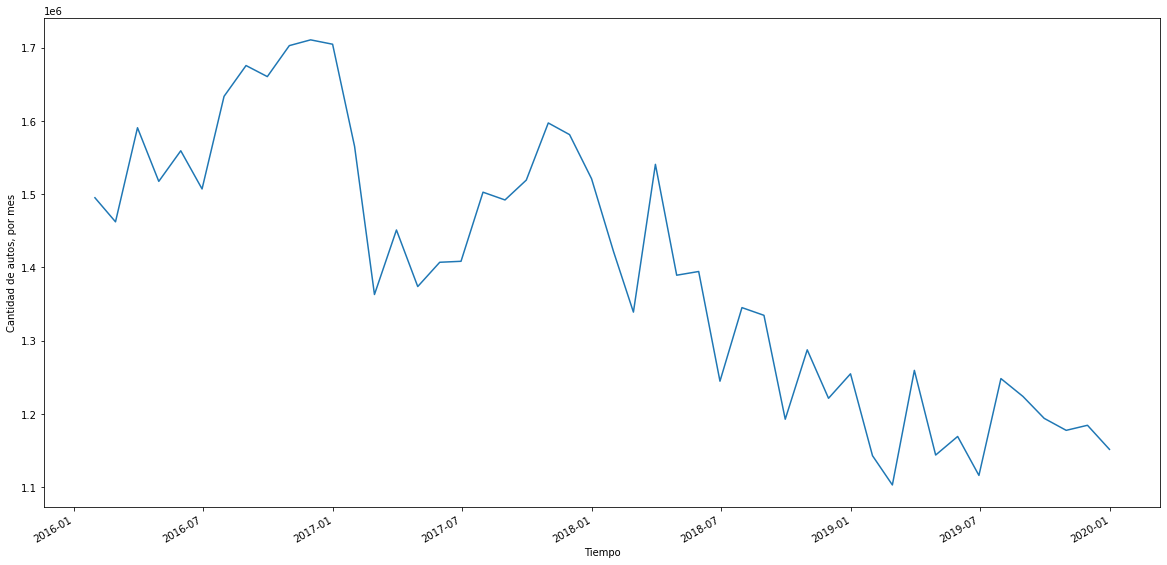

In [40]:
plt.figure(figsize = (20,10))
plt.plot(mes.index, mes.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.gcf().autofmt_xdate()
plt.show()

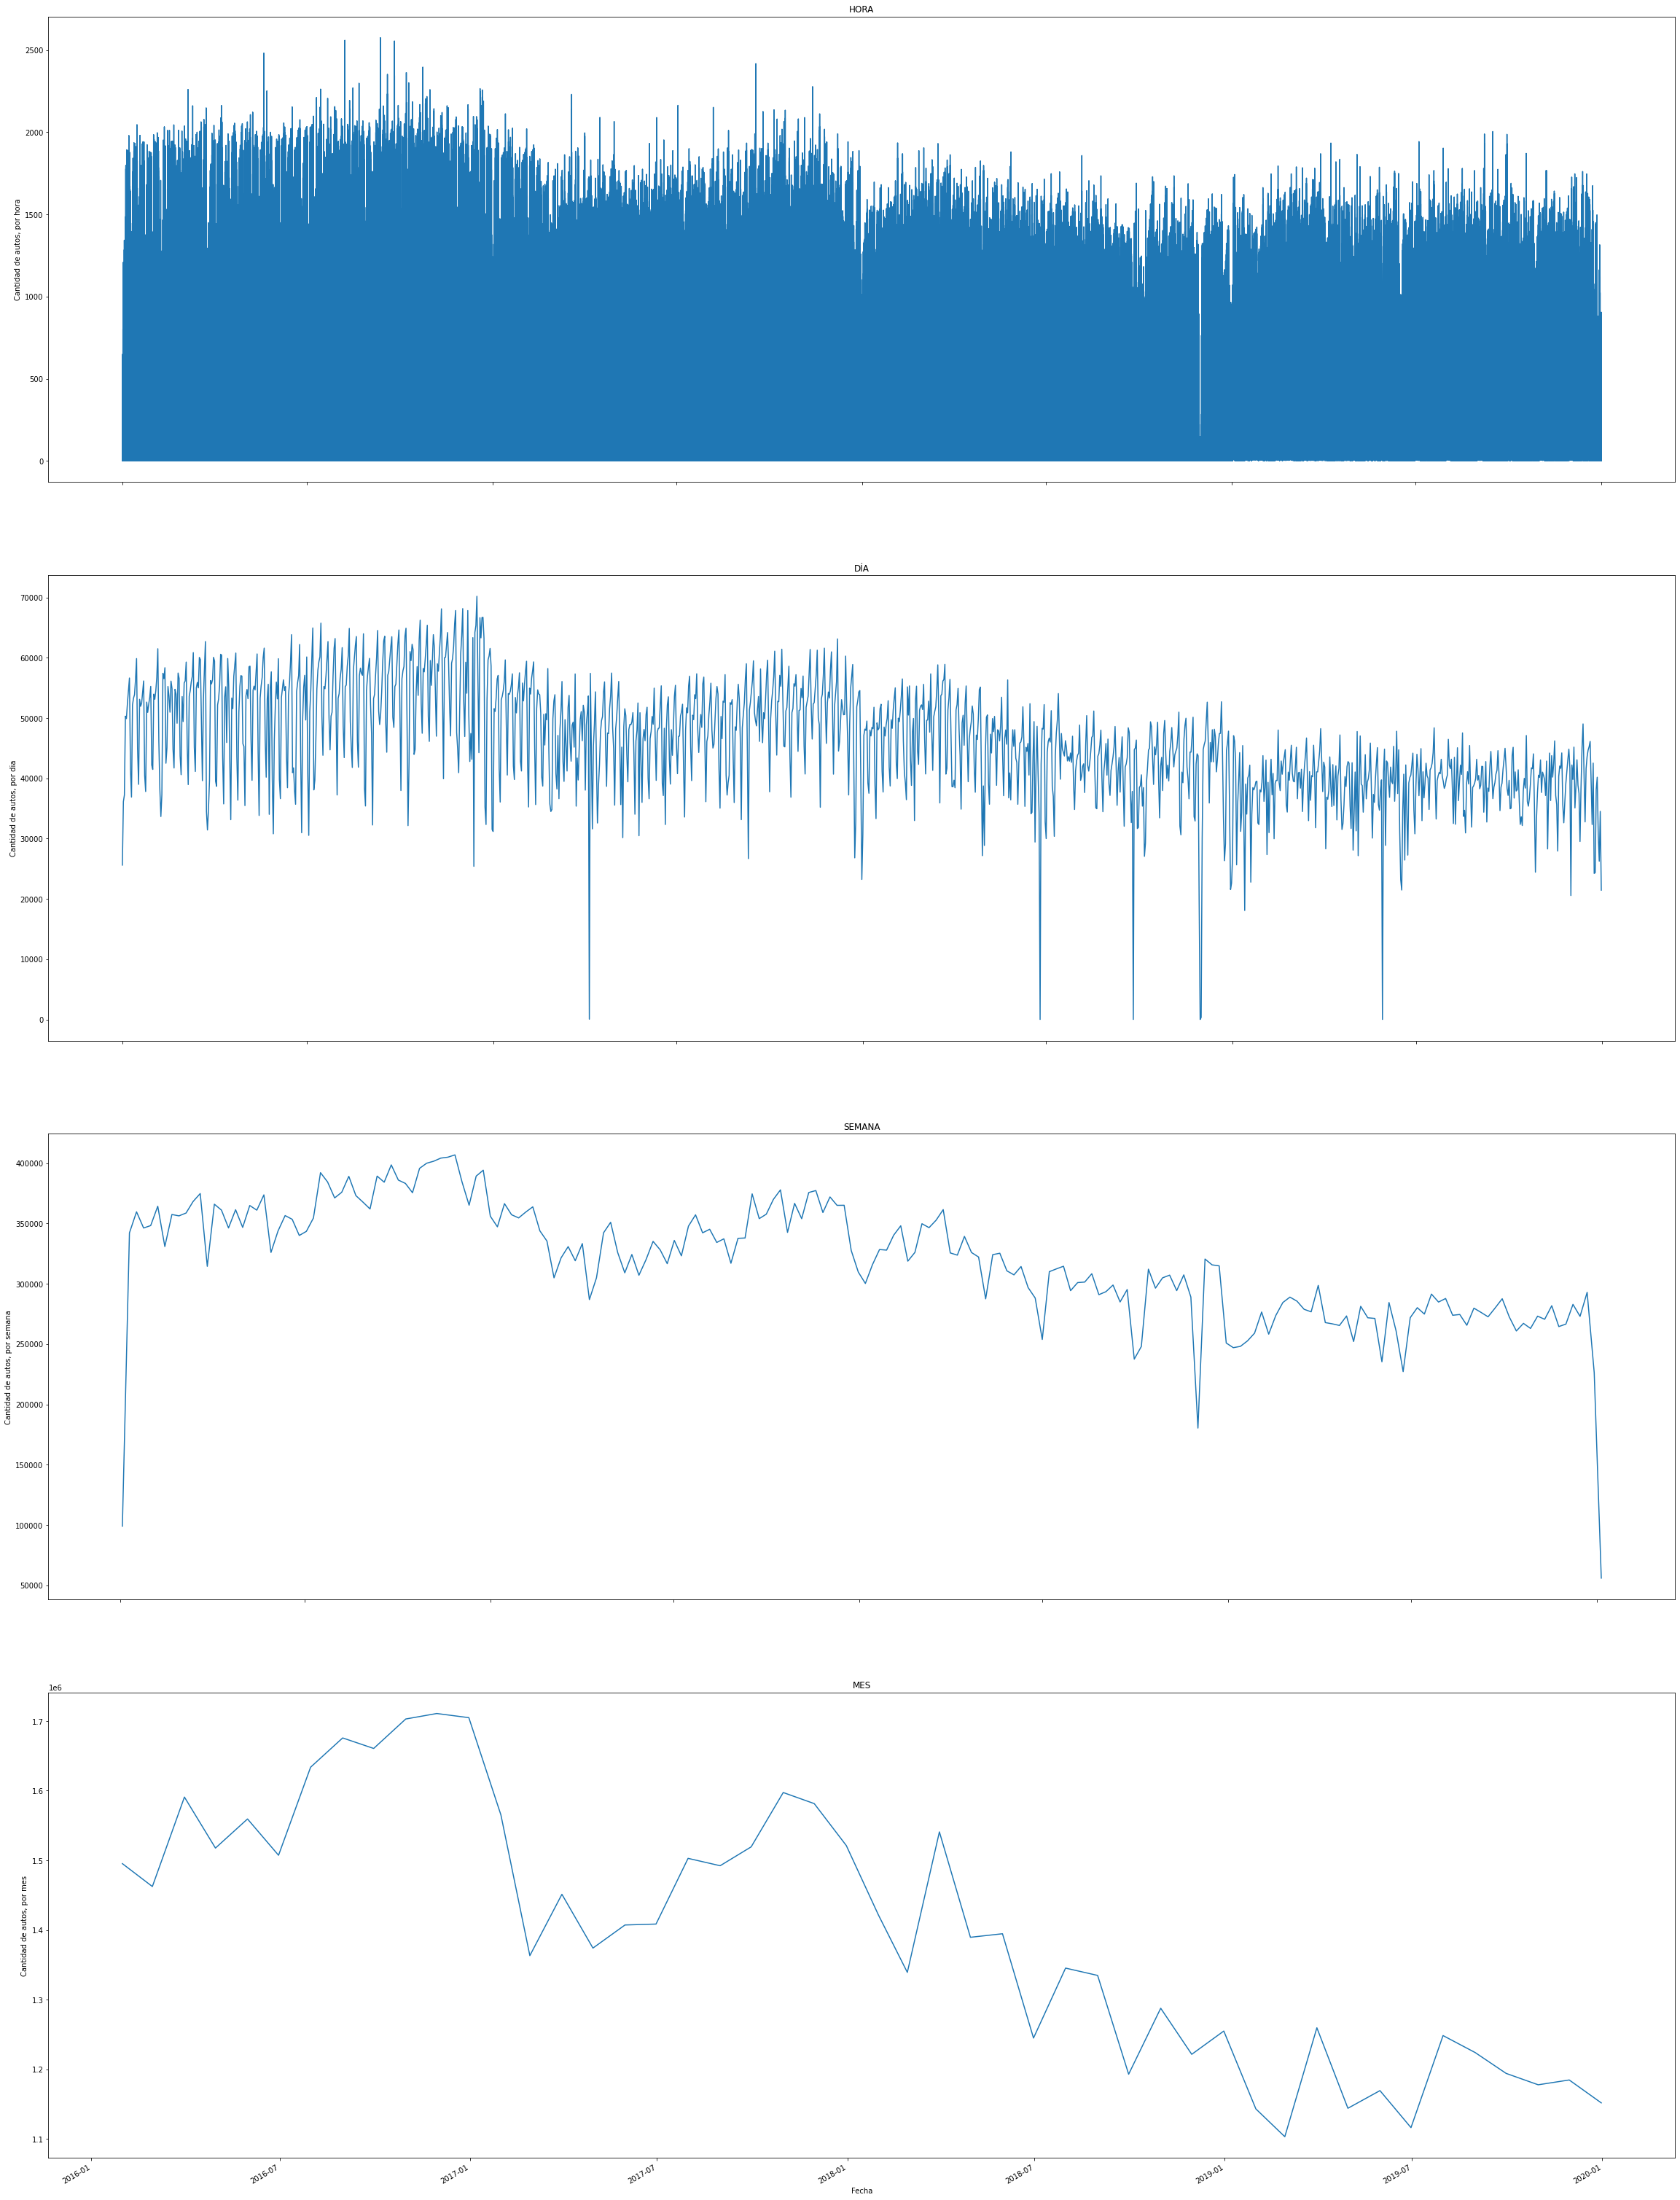

In [41]:
plt.figure(figsize = (40,60))

plt.subplot(4,1,1)
plt.title('HORA')
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.gcf().autofmt_xdate()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por hora')

plt.subplot(4,1,2)
plt.title('DÍA')
plt.plot(diario.index, diario.cantidad_pasos)
plt.gcf().autofmt_xdate()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(4,1,3)
plt.title('SEMANA')
plt.plot(semana.index, semana.cantidad_pasos)
plt.gcf().autofmt_xdate()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por semana')

plt.subplot(4,1,4)
plt.title('MES')
plt.plot(mes.index, mes.cantidad_pasos)
plt.gcf().autofmt_xdate()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por mes')

plt.show()

### Autocorrelación

In [42]:
from matplotlib import pyplot

In [43]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

autocorr_da = acf(diario.cantidad_pasos, nlags = 1460)

D:\Users\ovargas\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [44]:
autocorr_se = acf(semana.cantidad_pasos, nlags = 208)

In [45]:
autocorr_mo = acf(mes.cantidad_pasos, nlags = 48)

In [46]:
autocorr_ho = acf(dataset.cantidad_pasos, nlags = 8750*4)

In [47]:
print('Diario: ', autocorr_da.shape)
print('Semana: ', autocorr_se.shape)
print('Mes: ', autocorr_mo.shape)
print('Hora: ', autocorr_ho.shape)

Diario:  (1461,)
Semana:  (209,)
Mes:  (48,)
Hora:  (35001,)


Text(0.5, 0, 'lag')

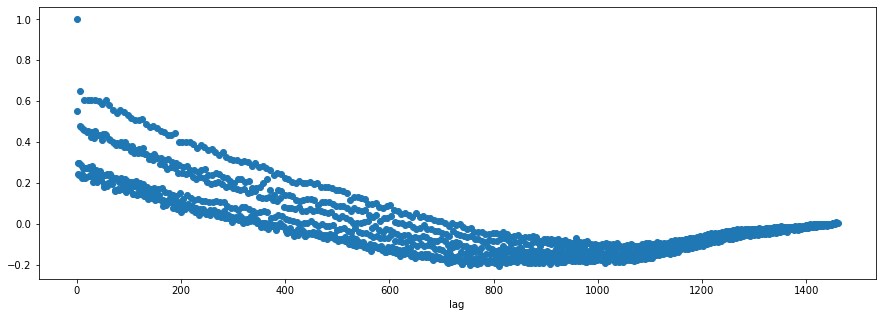

In [48]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(1461), autocorr_da)
plt.xlabel('lag')

Text(0.5, 0, 'lag')

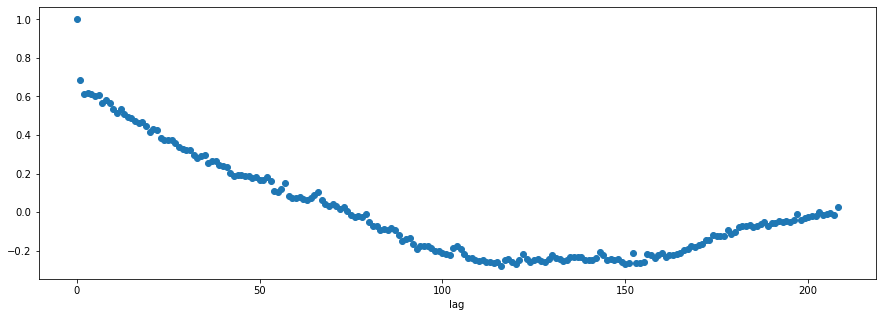

In [49]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(209), autocorr_se)
plt.xlabel('lag')

Text(0.5, 0, 'lag')

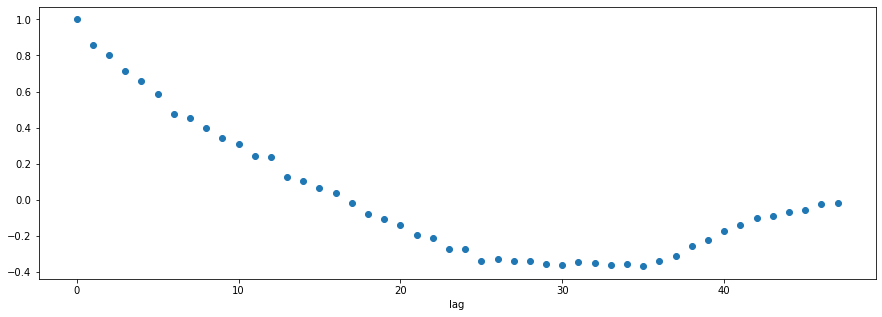

In [50]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(48), autocorr_mo)
plt.xlabel('lag')

Text(0.5, 0, 'lag')

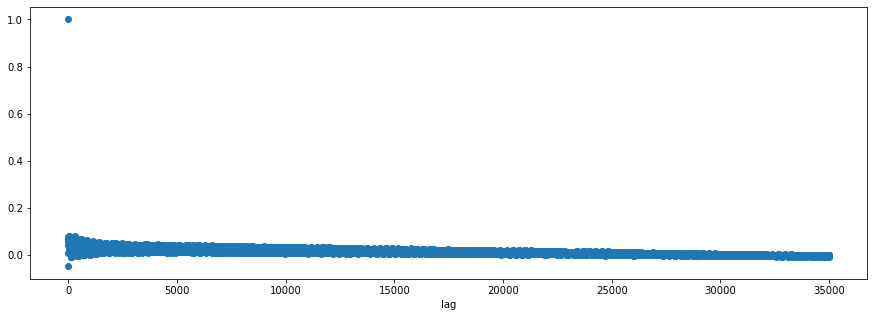

In [51]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(35001), autocorr_ho)
plt.xlabel('lag')

Figure(432x288)


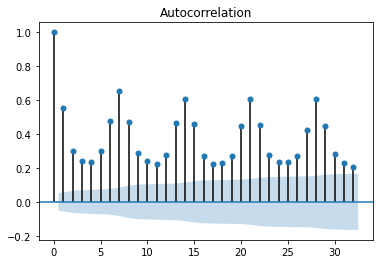

In [52]:
print(plot_acf(diario))

Figure(432x288)


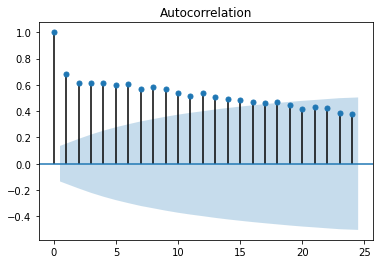

In [53]:
print(plot_acf(semana))

Figure(432x288)


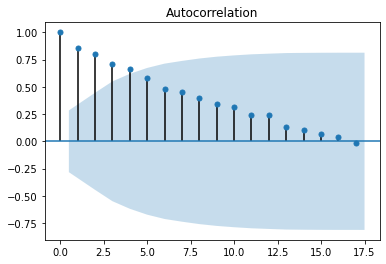

In [54]:
print(plot_acf(mes))

Figure(432x288)


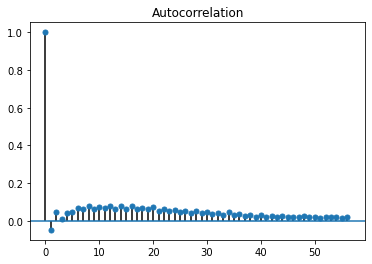

In [55]:
print(plot_acf(dataset.cantidad_pasos))

## Predicción a futuro: Semanal

In [56]:
senial = semana.cantidad_pasos
senial.head()

fecha
2016-01-03     98963
2016-01-10    342201
2016-01-17    359649
2016-01-24    346217
2016-01-31    348221
Freq: W-SUN, Name: cantidad_pasos, dtype: int64

En primer lugar, debemos definir cuántos valores *hacia atrás* tomaremos.

In [57]:
look_back = 52 # usamos un año de datos para predecir el valor siguiente

Creamos los `X` e `y` con ceros para luego llenar con los datos. Notar los `shape`

In [58]:
N = senial.shape[0]
X = np.zeros((N - look_back,look_back))
y = np.zeros(N - look_back)
print(X.shape, y.shape)

(158, 52) (158,)


Llenamos los `X` e `y`

In [59]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

Es importante notar que el tiempo de la medición - fecha - ya no es parte de los datos.

Hacemos el train/test split. Esta parte puede ser confusa, por lo que presta atención a cómo lo hacemos.

In [60]:
N_train = 3*52 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 52 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(104, 52) (104,)
(52, 52) (52,)


Entrenamos

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

Graficamos la importancia de cada feature.

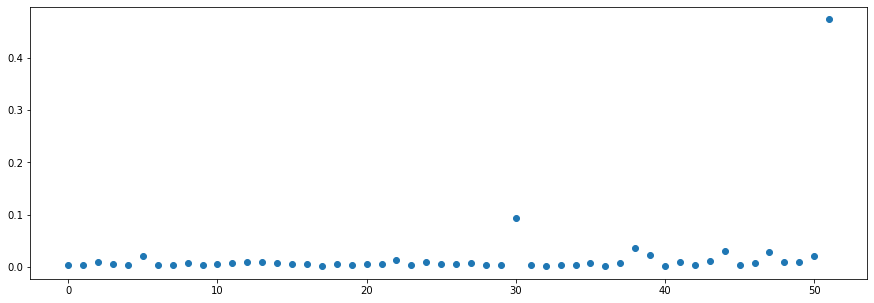

In [62]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
# for x in np.arange(3)*52:
#     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

Predecimos

In [63]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Y graficamos. Este gráfico también puede ser confuso, por lo que presta atención a cada línea. Si quieres, puedes ir comentando y descomentando cada línea para ver bien qué está haciendo y que el gráfico no quede tan sobrecargado.

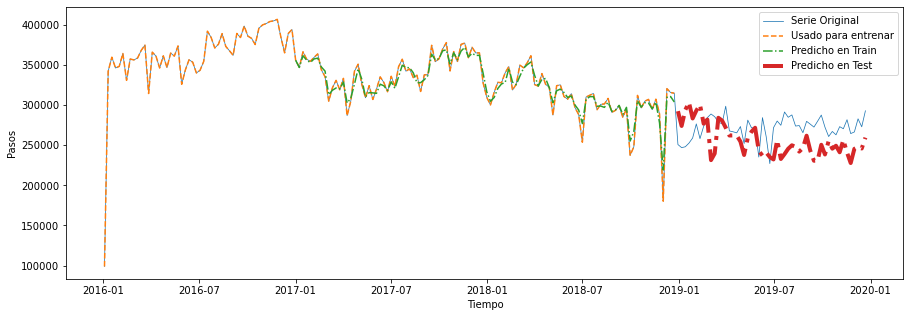

In [64]:
plt.figure(figsize=(15,5))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos')
plt.show()

Calculamos el error RMSE en train y test.

In [65]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 8178.274761766923
Error en Test: 30420.457477399625


**Benchmark**: comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.

In [66]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

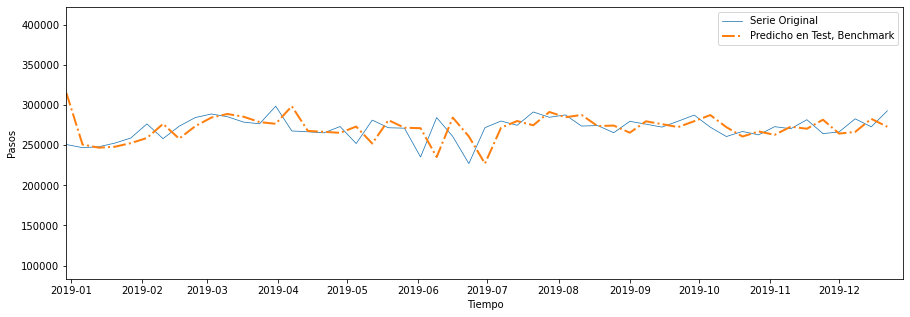

In [67]:
plt.figure(figsize=(15,5))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Pasos')
plt.legend()
plt.show()

In [68]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

18759.560466701936


Por lo que parece que, si bien no mucho, el modelo mejora la predicción por sobre el benchmark en el conjunto de test.

### Multi-Step Prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [69]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

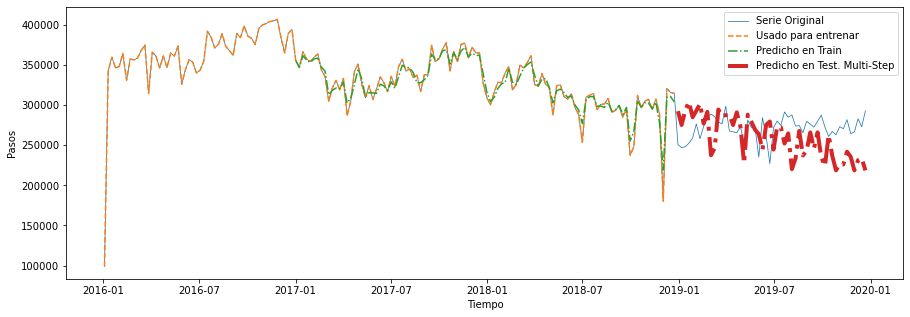

In [70]:
plt.figure(figsize=(15,5))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos')
plt.show()

Y calculamos el error RMSE

In [71]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 34184.39429439753


### Prophet: Semanal

In [72]:
df = dataset.reset_index()

In [73]:
sem1 = df.resample('W', on = 'fecha').sum()

In [74]:
sem1 = sem1.reset_index()

In [75]:
sem1=sem1.rename(columns={'fecha':'ds', 'cantidad_pasos':'y'})

In [76]:
sem1

,ds,index,y
0,2016-01-03,252405,98963
1,2016-01-10,3265473,342201
2,2016-01-17,6958875,359649
3,2016-01-24,10237513,346217
4,2016-01-31,13651929,348221
...,...,...,...
205,2019-12-08,230856879,282891
206,2019-12-15,230617011,272960
207,2019-12-22,232101744,292881
208,2019-12-29,227011096,226390


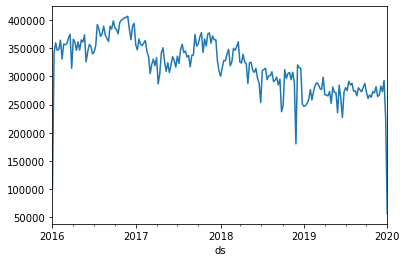

In [77]:
sem1.set_index('ds').y.plot()

In [78]:
sem1['y_orig'] = sem1['y'] # to save a copy of the original data..you'll see why shortly. 
# log-transform y
sem1['y'] = np.log(sem1['y'])

In [79]:
sem1.tail()

,ds,index,y,y_orig
205,2019-12-08,230856879,12.552817,282891
206,2019-12-15,230617011,12.517081,272960
207,2019-12-22,232101744,12.587522,292881
208,2019-12-29,227011096,12.330014,226390
209,2020-01-05,63751124,10.932571,55970


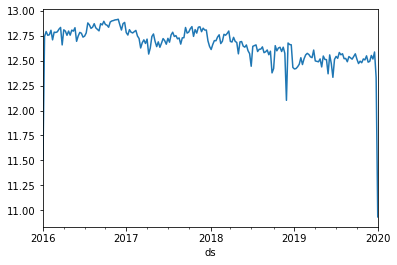

In [80]:
sem1.set_index('ds').y.plot()

In [81]:
models = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
models.fit(sem1);

In [82]:
future = models.make_future_dataframe(periods=39, freq = 'W')
future.tail()

,ds
244,2020-09-06
245,2020-09-13
246,2020-09-20
247,2020-09-27
248,2020-10-04


In [83]:
forecast = models.predict(future)

In [84]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-03,11.643330,12.282513,12.625481,11.643330,11.643330,0.802375,0.802375,0.802375,0.612681,...,0.45951,0.45951,0.45951,-0.269816,-0.269816,-0.269816,0.0,0.0,0.0,12.445704
1,2016-01-10,11.646649,12.295517,12.617394,11.646649,11.646649,0.815632,0.815632,0.815632,0.612681,...,0.45951,0.45951,0.45951,-0.256559,-0.256559,-0.256559,0.0,0.0,0.0,12.462281
2,2016-01-17,11.649969,12.424233,12.772214,11.649969,11.649969,0.952639,0.952639,0.952639,0.612681,...,0.45951,0.45951,0.45951,-0.119552,-0.119552,-0.119552,0.0,0.0,0.0,12.602607
3,2016-01-24,11.653288,12.575780,12.914762,11.653288,11.653288,1.092210,1.092210,1.092210,0.612681,...,0.45951,0.45951,0.45951,0.020019,0.020019,0.020019,0.0,0.0,0.0,12.745498
4,2016-01-31,11.656608,12.621141,12.958231,11.656608,11.656608,1.135133,1.135133,1.135133,0.612681,...,0.45951,0.45951,0.45951,0.062942,0.062942,0.062942,0.0,0.0,0.0,12.791741


In [85]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
244,2020-09-06,11.217372,12.130704,12.474085,11.188168,11.242144,1.089543,1.089543,1.089543,0.612681,...,0.45951,0.45951,0.45951,0.017352,0.017352,0.017352,0.0,0.0,0.0,12.306914
245,2020-09-13,11.214410,12.129419,12.466895,11.183952,11.240712,1.087084,1.087084,1.087084,0.612681,...,0.45951,0.45951,0.45951,0.014894,0.014894,0.014894,0.0,0.0,0.0,12.301494
246,2020-09-20,11.211447,12.126334,12.490555,11.180016,11.238890,1.105498,1.105498,1.105498,0.612681,...,0.45951,0.45951,0.45951,0.033307,0.033307,0.033307,0.0,0.0,0.0,12.316945
247,2020-09-27,11.208485,12.159292,12.486827,11.175785,11.237283,1.124551,1.124551,1.124551,0.612681,...,0.45951,0.45951,0.45951,0.052360,0.052360,0.052360,0.0,0.0,0.0,12.333036
248,2020-10-04,11.205523,12.143127,12.492661,11.171534,11.235437,1.116084,1.116084,1.116084,0.612681,...,0.45951,0.45951,0.45951,0.043893,0.043893,0.043893,0.0,0.0,0.0,12.321607


In [86]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
244,2020-09-06,12.306914,12.130704,12.474085
245,2020-09-13,12.301494,12.129419,12.466895
246,2020-09-20,12.316945,12.126334,12.490555
247,2020-09-27,12.333036,12.159292,12.486827
248,2020-10-04,12.321607,12.143127,12.492661


### Predicción de 2020

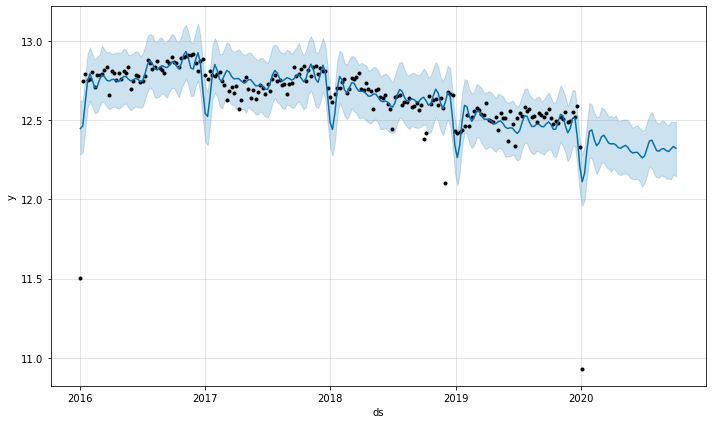

In [87]:
models.plot(forecast);

In [88]:
#forecast_orig = forecast # make sure we save the original forecast data
#forecast_orig['yhat'] = np.exp(forecast_orig['yhat'])
#forecast_orig['yhat_lower'] = np.exp(forecast_orig['yhat_lower'])
#forecast_orig['yhat_upper'] = np.exp(forecast_orig['yhat_upper'])

In [89]:
#sem1['y_log']=sem1['y'] #copy the log-transformed data to another column
#sem1['y']=sem1['y_orig'] #copy the original data to 'y'

In [90]:
#print(models.plot(forecast_orig))

#### 3. Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

Figure(648x864)


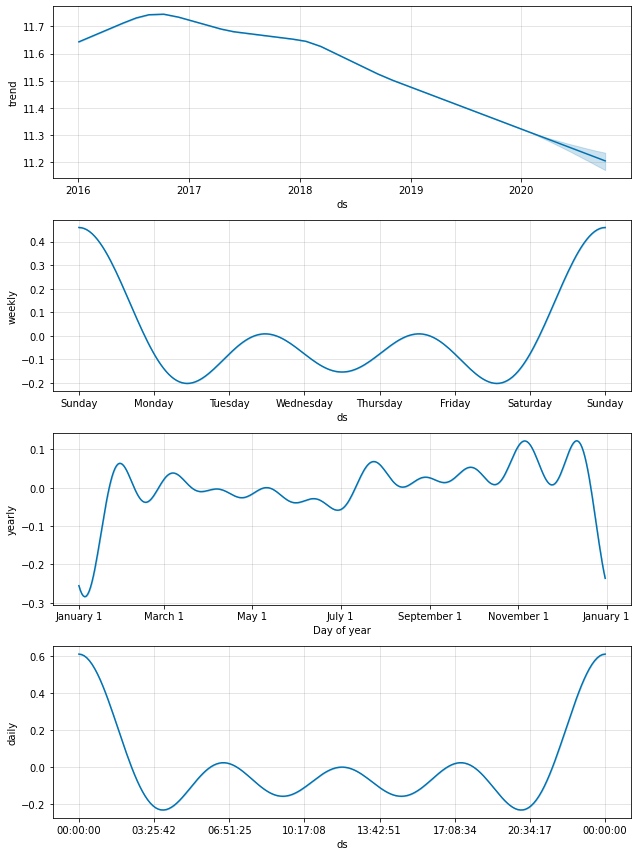

In [91]:
print(models.plot_components(forecast))

## Predicción a futuro: mensual

In [92]:
menial = mes.cantidad_pasos
menial.head()

fecha
2016-01-31    1495251
2016-02-29    1462367
2016-03-31    1590835
2016-04-30    1517590
2016-05-31    1559386
Freq: M, Name: cantidad_pasos, dtype: int64

En primer lugar, debemos definir cuántos valores *hacia atrás* tomaremos.

In [93]:
look_backm = 12 # usamos un año de datos para predecir el valor siguiente

Creamos los `X` e `y` con ceros para luego llenar con los datos. Notar los `shape`

In [94]:
N = menial.shape[0]
X = np.zeros((N - look_backm,look_backm))
y = np.zeros(N - look_backm)
print(X.shape, y.shape)

(36, 12) (36,)


Llenamos los `X` e `y`

In [95]:
for i in range(X.shape[0]):
#     X[i,:] = menial.values.iloc[i:i+look_back]
#     y[i] = menial.values.iloc[i+look_back]
    X[i,:] = menial.iloc[i:i+look_backm]
    y[i] = menial.iloc[i+look_backm]

Es importante notar que el tiempo de la medición - fecha - ya no es parte de los datos.

Hacemos el train/test split. Esta parte puede ser confusa, por lo que presta atención a cómo lo hacemos.

In [96]:
N_train = 3*12 - look_backm # cantidad de instancias que vamos a usar para entrenar. 
N_test = 12 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_backm

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(24, 12) (24,)
(12, 12) (12,)


Entrenamos

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rfm = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

Graficamos la importancia de cada feature.

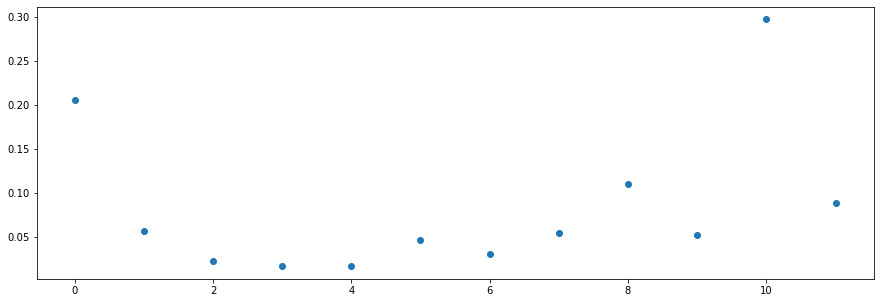

In [98]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(rfm.feature_importances_.size),rfm.feature_importances_)
# for x in np.arange(3)*52:
#     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

Predecimos

In [99]:
y_pred = rfm.predict(X)
y_train_pred = rfm.predict(X_train)
y_test_pred = rfm.predict(X_test)

Y graficamos. Este gráfico también puede ser confuso, por lo que presta atención a cada línea. Si quieres, puedes ir comentando y descomentando cada línea para ver bien qué está haciendo y que el gráfico no quede tan sobrecargado.

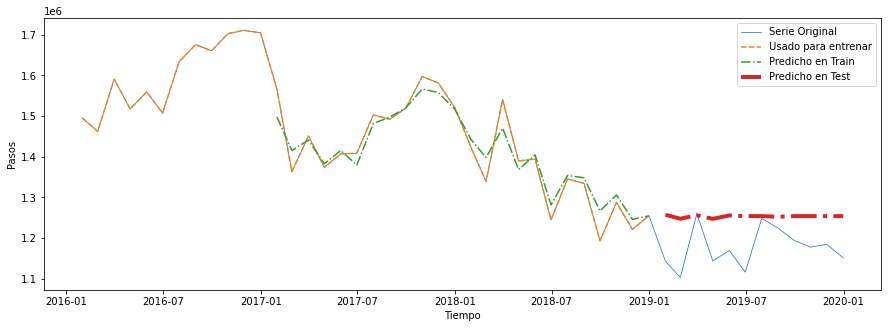

In [101]:
plt.figure(figsize=(15,5))
plt.plot(menial.index[:length_total], menial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(menial.index[:N_train + look_backm], menial[:N_train + look_backm],'--', label = 'Usado para entrenar')
plt.plot(menial.index[look_backm: look_backm + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(menial.index[N_train+look_backm: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos')
plt.show()

Calculamos el error RMSE en train y test.

In [102]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 34032.26834986537
Error en Test: 89707.45744286549


**Benchmark**: comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.

In [103]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

IndexError: index 48 is out of bounds for axis 0 with size 48

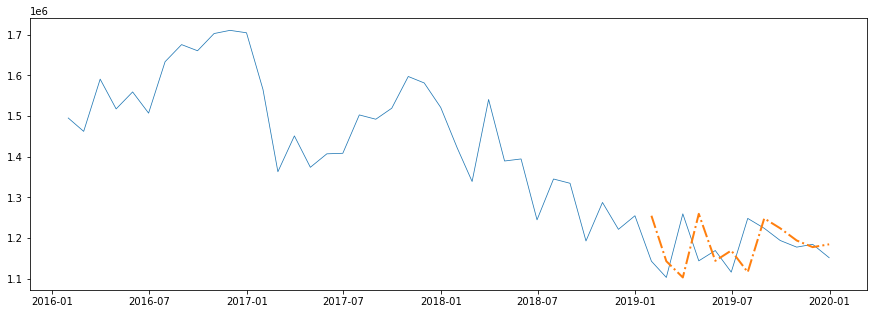

In [104]:
plt.figure(figsize=(15,5))
plt.plot(menial.index[:length_total], menial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(menial.index[N_train+look_backm: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(menial.index[N_train+look_backm], menial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Pasos')
plt.legend()
plt.show()

In [105]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

79462.94217327554


Por lo que parece que, si bien no mucho, el modelo mejora la predicción por sobre el benchmark en el conjunto de test.

### Multi-Step Prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [106]:
y_ms_test_predm = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_predm = rfm.predict(x.reshape(1,-1))
    y_ms_test_predm.append(y_os_predm)
    x = np.append(x[1:], y_os_predm)
y_ms_test_predm = np.array(y_ms_test_predm)

ValueError: x and y must have same first dimension, but have shapes (0,) and (24,)

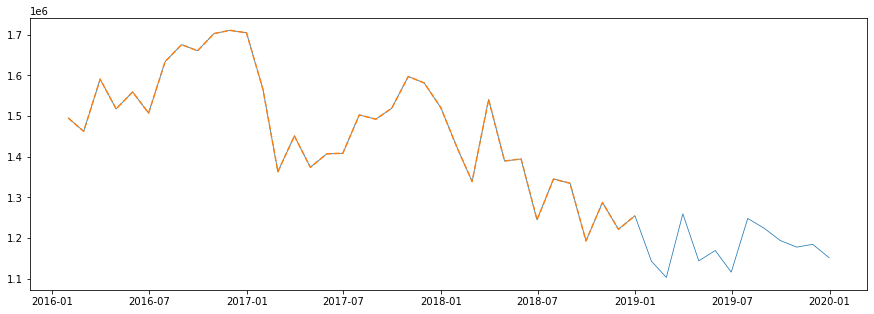

In [107]:
plt.figure(figsize=(15,5))
plt.plot(menial.index[:length_total], menial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(menial.index[:N_train + look_backm], menial[:N_train + look_backm],'--', label = 'Usado para entrenar')
plt.plot(menial.index[look_back: look_backm + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(menial.index[N_train+look_backm: length_total], y_ms_test_predm,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos')
plt.show()

Y calculamos el error RMSE

In [127]:
MSE = mean_squared_error(y_test, y_ms_test_predm)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 89279.10374398399


### Prophet

In [109]:
dfm = dataset.reset_index()

In [110]:
mes1 = dfm.resample('M', on = 'fecha').sum()

In [111]:
mes1.describe()

,index,cantidad_pasos
count,4.800000e+01,4.800000e+01
mean,1.251121e+09,1.397646e+06
std,6.692443e+08,1.800154e+05
min,3.436620e+07,1.103086e+06
25%,8.978075e+08,1.239572e+06
50%,1.026274e+09,1.400840e+06
75%,1.759068e+09,1.526092e+06
max,2.467473e+09,1.710827e+06


In [112]:
mes1 = mes1.reset_index()

In [113]:
mes1 = mes1.rename(columns={'fecha':'ds', 'cantidad_pasos':'y'})

In [114]:
mes1

,ds,index,y
0,2016-01-31,34366195,1495251
1,2016-02-29,101981646,1462367
2,2016-03-31,196175525,1590835
3,2016-04-30,263240055,1517590
4,2016-05-31,353300107,1559386
5,2016-06-30,418764528,1507250
6,2016-07-31,522343814,1633704
7,2016-08-31,610381251,1675752
8,2016-09-30,678800290,1660642
9,2016-10-31,786443859,1702953


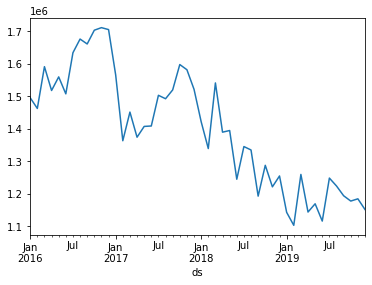

In [115]:
mes1.set_index('ds').y.plot()

In [116]:
mes1['y_orig'] = mes1['y'] # to save a copy of the original data..you'll see why shortly. 
# log-transform y
mes1['y'] = np.log(mes1['y'])

In [117]:
mes1.tail()

,ds,index,y,y_orig
43,2019-08-31,987434280,14.017627,1223990
44,2019-09-30,962076830,13.992820,1194001
45,2019-10-31,1005351826,13.979029,1177647
46,2019-11-30,980792489,13.984882,1184560
47,2019-12-31,1006333470,13.956702,1151645


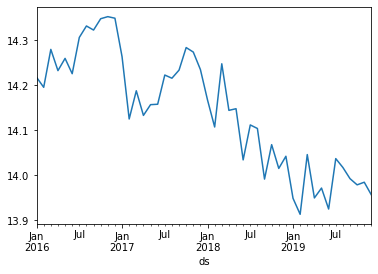

In [118]:
mes1.set_index('ds').y.plot()

In [119]:
modelm = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
modelm.fit(mes1);

In [120]:
futurem = modelm.make_future_dataframe(periods=9, freq = 'M')
futurem.tail()

,ds
52,2020-05-31
53,2020-06-30
54,2020-07-31
55,2020-08-31
56,2020-09-30


In [121]:
forecastm = modelm.predict(futurem)

In [122]:
forecastm.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-31,0.844876,14.208918,14.233283,0.844876,0.844876,13.376930,13.376930,13.376930,13.517855,...,-0.034753,-0.034753,-0.034753,-0.106171,-0.106171,-0.106171,0.0,0.0,0.0,14.221807
1,2016-02-29,0.810688,14.179340,14.203576,0.810688,0.810688,13.380949,13.380949,13.380949,13.517855,...,0.000467,0.000467,0.000467,-0.137373,-0.137373,-0.137373,0.0,0.0,0.0,14.191637
2,2016-03-31,0.774142,14.256305,14.282488,0.774142,0.774142,13.495200,13.495200,13.495200,13.517855,...,0.003648,0.003648,0.003648,-0.026303,-0.026303,-0.026303,0.0,0.0,0.0,14.269342
3,2016-04-30,0.738775,14.231246,14.255486,0.738775,0.738775,13.504472,13.504472,13.504472,13.517855,...,-0.011244,-0.011244,-0.011244,-0.002140,-0.002140,-0.002140,0.0,0.0,0.0,14.243247
4,2016-05-31,0.702357,14.245778,14.269907,0.702357,0.702357,13.554750,13.554750,13.554750,13.517855,...,0.024948,0.024948,0.024948,0.011947,0.011947,0.011947,0.0,0.0,0.0,14.257107


In [123]:
forecastm.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
52,2020-05-31,0.334888,13.734076,13.933213,0.237333,0.435730,13.495048,13.495048,13.495048,13.517855,...,-0.034753,-0.034753,-0.034753,0.011947,0.011947,0.011947,0.0,0.0,0.0,13.829936
53,2020-06-30,0.324625,13.740839,14.001044,0.197957,0.459345,13.538296,13.538296,13.538296,13.517855,...,0.024948,0.024948,0.024948,-0.004508,-0.004508,-0.004508,0.0,0.0,0.0,13.862921
54,2020-07-31,0.314020,13.754210,14.094847,0.147191,0.490970,13.604184,13.604184,13.604184,13.517855,...,-0.000943,-0.000943,-0.000943,0.087272,0.087272,0.087272,0.0,0.0,0.0,13.918203
55,2020-08-31,0.303414,13.667949,14.092372,0.100117,0.524729,13.566955,13.566955,13.566955,13.517855,...,0.000467,0.000467,0.000467,0.048634,0.048634,0.048634,0.0,0.0,0.0,13.870369
56,2020-09-30,0.293151,13.633930,14.143429,0.049622,0.555952,13.584029,13.584029,13.584029,13.517855,...,0.017877,0.017877,0.017877,0.048298,0.048298,0.048298,0.0,0.0,0.0,13.877180


In [124]:
forecastm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
52,2020-05-31,13.829936,13.734076,13.933213
53,2020-06-30,13.862921,13.740839,14.001044
54,2020-07-31,13.918203,13.754210,14.094847
55,2020-08-31,13.870369,13.667949,14.092372
56,2020-09-30,13.877180,13.633930,14.143429


### Predicción de 2020: Mensual

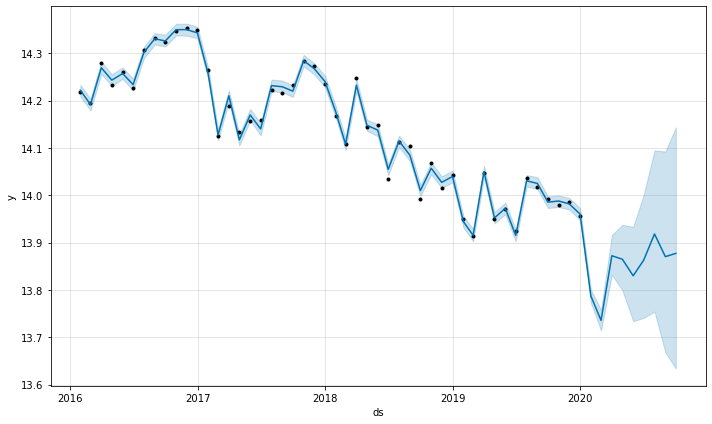

In [125]:
modelm.plot(forecastm);

#### 3. Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

Figure(648x864)


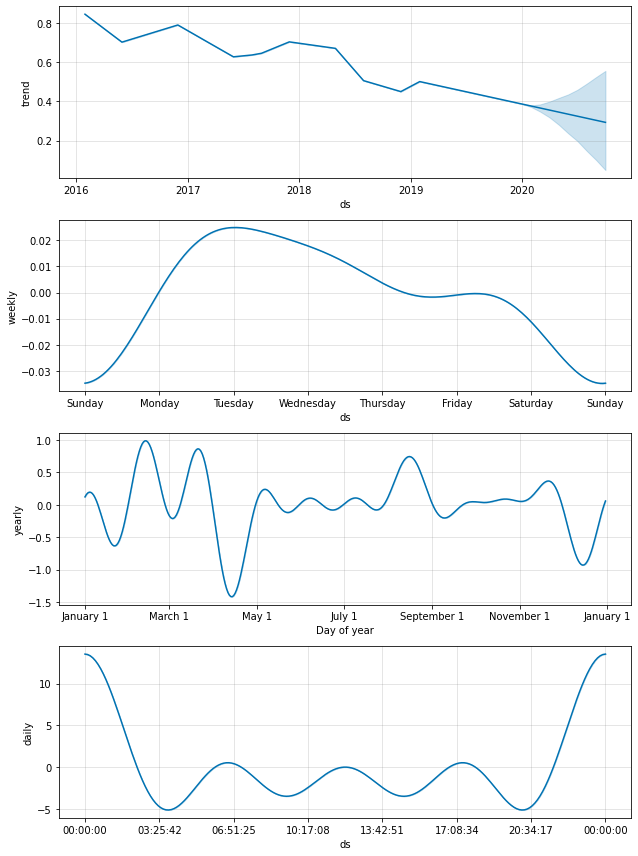

In [126]:
print(modelm.plot_components(forecastm))